# VQC, SVM, and Feature Map

The contents of this notebook are strongly based on the following paper:
https://arxiv.org/pdf/1804.11326.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.circuit.library import ZZFeatureMap
%matplotlib inline

def expectationZBasis(counts, shots):
    expectation = 0
    for key in counts:
        sign = 1
        if key.count("1") % 2 == 1:
            sign = -1
        expectation += sign * counts[key] / shots
    return expectation

## Feature Maps

In [2]:
def ZFeatureMap(qubits, x, numMeasurements=None):
    if np.sum(np.iscomplex(x)) != 0:
        raise Exception("x must be real in the feature map encoding")
    if numMeasurements is None:
        numMeasurements = qubits
    circ = QuantumCircuit(qubits, numMeasurements)
    for i in range(qubits):
        circ.h(i)
        circ.p(2*x[i], i) # TODO Check p gate is the same as the u1 gate
        circ.h(i)
        circ.p(2*x[i], i)
    return circ

# There may be a better name for this
def RyFeatureMap(qubits, x, numMeasurements=None):
    if np.sum(np.iscomplex(x)) != 0:
        raise Exception("x must be real in the feature map encoding")
    if numMeasurements is None:
        numMeasurements = qubits
    circ = QuantumCircuit(qubits, numMeasurements)
    for i in range(qubits):
        circ.ry(2*x[i], i)
    return circ

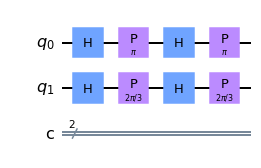

In [3]:
fmap = ZFeatureMap(2, np.array([np.pi/2, np.pi/3]))
fmap.draw('mpl')

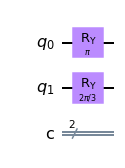

In [4]:
fmap = RyFeatureMap(2, np.array([np.pi/2, np.pi/3]))
fmap.draw('mpl')

## VQC

In [5]:
def U(theta, layer, numMeasurements=None):
    rotations, qubits, layers = theta.shape
    if rotations != 2:
        raise Exception("First dimension of theta must be 2!")
    if layer >= layers:
        raise Exception("Layer {} is greater than number of layers!".format(layer))
    
    if numMeasurements is None:
        numMeasurements = qubits
    
    circ = QuantumCircuit(qubits, numMeasurements)
    for q in range(qubits):
        circ.ry(theta[0][q][layer], q)
        circ.rz(theta[1][q][layer], q)
    return circ

def U_ent(qubits, numMeasurements=None):
    if qubits < 2:
        raise Exception("Not enough qubits to create U_ent")
    if numMeasurements is None:
        numMeasurements = qubits
    circ = QuantumCircuit(qubits, numMeasurements)
    
    for i in range(qubits-1):
        circ.cz(i, i+1)
    
    if qubits != 2:
        circ.cz(qubits-1, 0) # TODO Check, this may be qc.cz(0, qubits-1)
    return circ

def buildCircuit(theta, numMeasurements=None):
    rotations, qubits, layers = theta.shape
    if rotations != 2:
        raise Exception("First dimension of theta must be 2!")
    
    if numMeasurements is None:
        numMeasurements = qubits
    circ = QuantumCircuit(qubits, numMeasurements)
    for i in range(layers-1):
        circ += U(theta, i, numMeasurements)
        circ += U_ent(qubits, numMeasurements)
    circ += U(theta, layers-1, numMeasurements)
    
    # Add Measurments
    circ.measure(range(numMeasurements), range(numMeasurements))
    
    return circ

Theta:
[[[-0.13042962 -1.92457635  0.08841918  1.29456803]
  [-0.30531456 -0.13383833 -0.20536631  0.9436554 ]]

 [[-0.44354268 -0.98087701 -0.12997854  2.0778786 ]
  [-0.41742989 -1.2450374   1.00423781  0.18411969]]]


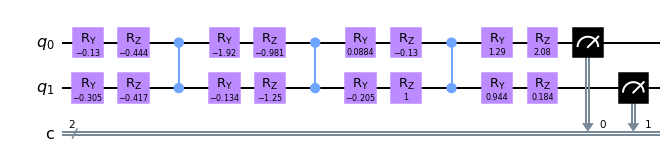

In [6]:
qubits = 2
layers = 4
theta = np.random.randn(2, qubits, layers)
circ = buildCircuit(theta)
print("Theta:")
print(theta)
circ.draw("mpl")

Theta:
[[[-0.09335867  1.36310355 -1.80379505 -0.02540924 -0.37660512]
  [ 0.12066255 -2.97563551 -0.24290034 -0.41955904 -0.67824244]
  [-1.64147716 -0.43251753  0.12701157 -0.01882966 -0.71402609]]

 [[ 0.5189009   1.44805989 -0.70674557 -1.07395337 -1.55882981]
  [-0.29648719 -1.48646356  0.49599835 -0.00681119 -0.94224744]
  [ 0.05757628  0.68086345 -0.30091078  0.10324876 -0.46772786]]]


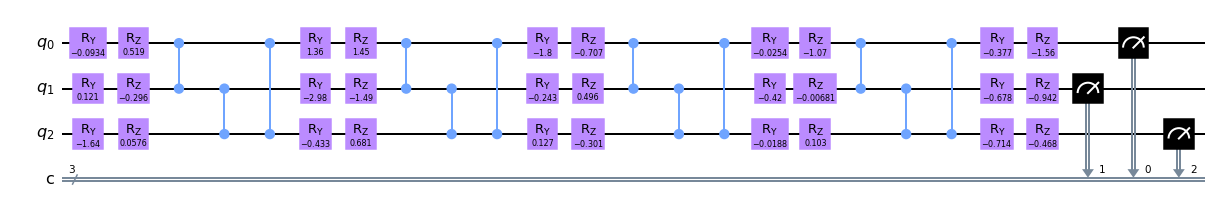

In [7]:
qubits = 3
layers = 5
theta = np.random.randn(2, qubits, layers)
circ = buildCircuit(theta)
print("Theta:")
print(theta)
circ.draw("mpl")

### Training

In [8]:
def f(theta, bias, x, featureMap, shots=2048):
    rotations, qubits, layers = theta.shape
    circ = featureMap(qubits, x) + buildCircuit(theta)
    
    # Run the quantum circuit
    backend = Aer.get_backend("qasm_simulator")
    
    job = execute(circ, backend, shots=shots)
    res = job.result()
    counts = res.get_counts()
    return expectationZBasis(counts, shots) + bias

def classify(theta, bias, x, featureMap, shots=2048):
    return 1 if f(theta, bias, x, shots) > 0 else -1

In [9]:
def MSELoss(yhats, ys, shots=2048):
    if len(yhats) != len(ys):
        raise Exception("Length of yhats must match length of ys")
    return np.sum((yhats - ys)**2)/len(ys)

def gradF(theta, maskTheta, bias, maskBias, x, featureMap, shots=2048, r=0.5):
    return r*(f(theta+maskTheta, bias+maskBias, x, featureMap, shots) - f(theta-maskTheta, bias-maskBias, x, featureMap, shots))

def gradMSE_theta(theta, bias, x, yhat, y, featureMap, shots=2048, r=0.5):
    s = np.pi/(4*r)
    grad = np.zeros_like(theta)
    mask = np.zeros_like(theta)
    for i in range(len(theta)):
        for j in range(len(theta[i])):
            for k in range(len(theta[i][j])):
                mask[i][j][k] = s
                func = lambda ind: 2*(yhat[ind] - y[ind])*gradF(theta, mask, bias, 0, x[ind], featureMap, shots=shots, r=r)
                grad[i][j][k] = np.sum(np.vectorize(func)(np.arange(len(x))))
                mask[i][j][k] = 0
    return grad/len(x)

def gradMSE_b(theta, bias, x, yhat, y, featureMap, shots=2048, r=0.5):
    s = np.pi/(4*r)
    mask = np.zeros_like(theta)
    func = lambda ind: 2*(yhat[ind] - y[ind])*gradF(theta, mask, bias, s, x[ind], featureMap, shots, r)
    return np.sum(np.vectorize(func)(np.arange(len(x))))/len(x)

def train(x, y, featureMap, qubits=2, layers=2, numEpochs=100, eta=1e-3, shots=2048):
    theta = np.random.rand(2, qubits, layers)
    b = np.random.rand()
    
    for epoch in range(numEpochs):
        func = lambda x: f(theta, b, x, featureMap, shots)
        yhat = np.apply_along_axis(func, 1, x)
        if epoch % 5 == 0:
            print("Epoch: {}, Loss: {}".format(epoch, MSELoss(yhat, y, shots)))
        gradTheta = gradMSE_theta(theta, b, x, yhat, y, featureMap, shots)
        gradB = gradMSE_b(theta, b, x, yhat, y, featureMap, shots)
        theta = theta - eta*gradTheta
        b = b - eta*gradB
    return theta, b

## Breast Cancer Dataset

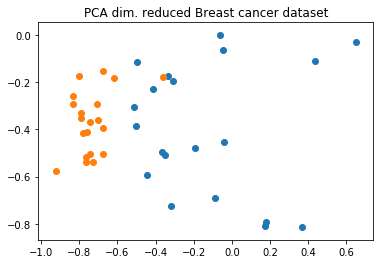

In [10]:
from qiskit.ml.datasets import breast_cancer

feature_dim = 2
sample_total, training_input, test_input, class_labels = breast_cancer(
    training_size=20,
    test_size=10,
    n=feature_dim,
    plot_data=True
)
datapoints, class_to_label = split_dataset_to_data_and_labels(training_input)
v_datapoints, _ = split_dataset_to_data_and_labels(test_input)

In [11]:
x = datapoints[0]
y = datapoints[1]
y[y == 0] = -1
order = np.arange(len(x))
np.random.shuffle(order)
x = x[order]
y = y[order]

In [12]:
v_x = v_datapoints[0]
v_y = v_datapoints[1]
v_y[v_y == 0] = -1
order = np.arange(len(v_x))
np.random.shuffle(order)
v_x = v_x[order]
v_y = v_y[order]

In [13]:
# Base
theta, b = train(x, y, RyFeatureMap, qubits=2, layers=2, numEpochs=100, eta=1e-3, shots=2048) # 2 qubits, 2 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, RyFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 3.8701990774568755
Epoch: 5, Loss: 3.766344114798092
Epoch: 10, Loss: 3.6735323201555437
Epoch: 15, Loss: 3.5973405515940096
Epoch: 20, Loss: 3.5173432595071183
Epoch: 25, Loss: 3.4505121613984597
Epoch: 30, Loss: 3.3593540501398507
Epoch: 35, Loss: 3.2766749543534823
Epoch: 40, Loss: 3.2067054637655175
Epoch: 45, Loss: 3.139290090853996
Epoch: 50, Loss: 3.078452234992929
Epoch: 55, Loss: 3.0052724203539873
Epoch: 60, Loss: 2.947069864230046
Epoch: 65, Loss: 2.894620675211218
Epoch: 70, Loss: 2.829508393747561
Epoch: 75, Loss: 2.773577575811367
Epoch: 80, Loss: 2.7151543434808807
Epoch: 85, Loss: 2.660380406638061
Epoch: 90, Loss: 2.599753009979723
Epoch: 95, Loss: 2.549415750588728
Test Loss: 2.5381335597679477


In [14]:
# Increase eta
theta, b = train(x, y, RyFeatureMap, qubits=2, layers=2, numEpochs=100, eta=1e-2, shots=2048) # 2 qubits, 2 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, RyFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 1.7585255342312407
Epoch: 5, Loss: 1.4573582333917616
Epoch: 10, Loss: 1.2738387323553717
Epoch: 15, Loss: 1.1309698697185522
Epoch: 20, Loss: 1.0534584299660605
Epoch: 25, Loss: 1.0124921864512637
Epoch: 30, Loss: 0.973473969659423
Epoch: 35, Loss: 0.9209856033156465
Epoch: 40, Loss: 0.9143690700671954
Epoch: 45, Loss: 0.8820101046823492
Epoch: 50, Loss: 0.8631951498767378
Epoch: 55, Loss: 0.8378485562269707
Epoch: 60, Loss: 0.8262807485636958
Epoch: 65, Loss: 0.7962784704754193
Epoch: 70, Loss: 0.7879964065380973
Epoch: 75, Loss: 0.7670231713831928
Epoch: 80, Loss: 0.7436069936523069
Epoch: 85, Loss: 0.7166289198354351
Epoch: 90, Loss: 0.7044890648620293
Epoch: 95, Loss: 0.7000823254010451
Test Loss: 0.7495068688063038


In [15]:
# Increase the number of layers to 3, keep increased eta
theta, b = train(x, y, RyFeatureMap, qubits=2, layers=3, numEpochs=100, eta=1e-2, shots=2048) # 2 qubits, 2 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, RyFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 2.5377837402541963
Epoch: 5, Loss: 1.8553411725749527
Epoch: 10, Loss: 1.428366249181041
Epoch: 15, Loss: 1.1517659656788888
Epoch: 20, Loss: 0.9818497547682006
Epoch: 25, Loss: 0.8875069468347394
Epoch: 30, Loss: 0.8133619882178834
Epoch: 35, Loss: 0.7657200393232593
Epoch: 40, Loss: 0.7154268844329049
Epoch: 45, Loss: 0.682734483130856
Epoch: 50, Loss: 0.6598099293226989
Epoch: 55, Loss: 0.6405388873104055
Epoch: 60, Loss: 0.618406792693485
Epoch: 65, Loss: 0.6057230671109137
Epoch: 70, Loss: 0.5822524020165336
Epoch: 75, Loss: 0.5719271254324345
Epoch: 80, Loss: 0.5531604693856538
Epoch: 85, Loss: 0.5467159584768657
Epoch: 90, Loss: 0.5318795948323676
Epoch: 95, Loss: 0.5149426225793494
Test Loss: 0.48094248360319874


In [19]:
# Increase the number of layers to 4, keep increased eta
theta, b = train(x, y, RyFeatureMap, qubits=2, layers=4, numEpochs=100, eta=1e-2, shots=2048) # 2 qubits, 2 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, RyFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 1.4152619936531134
Epoch: 5, Loss: 1.2462463233626646
Epoch: 10, Loss: 1.1380171561285874
Epoch: 15, Loss: 1.0347159528971115
Epoch: 20, Loss: 0.9614696641538112
Epoch: 25, Loss: 0.8950965275750751
Epoch: 30, Loss: 0.8461051798813163
Epoch: 35, Loss: 0.805275167071023
Epoch: 40, Loss: 0.7534066602655775
Epoch: 45, Loss: 0.7193076411625068
Epoch: 50, Loss: 0.691054841419811
Epoch: 55, Loss: 0.6696672630878513
Epoch: 60, Loss: 0.6308967163353759
Epoch: 65, Loss: 0.6168469447076731
Epoch: 70, Loss: 0.5865908574315031
Epoch: 75, Loss: 0.5671614508526875
Epoch: 80, Loss: 0.5570096001411919
Epoch: 85, Loss: 0.5457182544397077
Epoch: 90, Loss: 0.5271844835137267
Epoch: 95, Loss: 0.5160957466242696
Test Loss: 0.5346059248030693


In [16]:
# Different feature map results with eta = 1e-2
theta, b = train(x, y, ZFeatureMap, qubits=2, layers=2, numEpochs=100, eta=1e-2, shots=2048) # 2 qubits, 2 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, ZFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 1.2475073890434796
Epoch: 5, Loss: 1.2333832382966965
Epoch: 10, Loss: 1.217013435913286
Epoch: 15, Loss: 1.2038589722851103
Epoch: 20, Loss: 1.1857663982010798
Epoch: 25, Loss: 1.1764277950774613
Epoch: 30, Loss: 1.1696342327564857
Epoch: 35, Loss: 1.166836850902198
Epoch: 40, Loss: 1.1478234623712917
Epoch: 45, Loss: 1.1334970736716343
Epoch: 50, Loss: 1.1378958774779069
Epoch: 55, Loss: 1.1254208968009227
Epoch: 60, Loss: 1.116968083993386
Epoch: 65, Loss: 1.1076938777954926
Epoch: 70, Loss: 1.0997231283489828
Epoch: 75, Loss: 1.0941973468976747
Epoch: 80, Loss: 1.0983254687627781
Epoch: 85, Loss: 1.0860398330345862
Epoch: 90, Loss: 1.0787848195171468
Epoch: 95, Loss: 1.0662027285293507
Test Loss: 1.0798698183545576


In [17]:
# Different feature map results with eta = 1e-2 and 3 layers
theta, b = train(x, y, ZFeatureMap, qubits=2, layers=3, numEpochs=100, eta=1e-2, shots=2048) # 2 qubits, 2 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, ZFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 1.1796690168740513
Epoch: 5, Loss: 1.0892025912250234
Epoch: 10, Loss: 1.0042714839052187
Epoch: 15, Loss: 0.9457115935075535
Epoch: 20, Loss: 0.8953161309142044
Epoch: 25, Loss: 0.8584368392987105
Epoch: 30, Loss: 0.8235919642619018
Epoch: 35, Loss: 0.7812520840372916
Epoch: 40, Loss: 0.7457747704682044
Epoch: 45, Loss: 0.7162960122276647
Epoch: 50, Loss: 0.7110172102704546
Epoch: 55, Loss: 0.6778127046432305
Epoch: 60, Loss: 0.6530424105528658
Epoch: 65, Loss: 0.6442141173779946
Epoch: 70, Loss: 0.6225691198696823
Epoch: 75, Loss: 0.6096465386908784
Epoch: 80, Loss: 0.5870922664364958
Epoch: 85, Loss: 0.5873770768466569
Epoch: 90, Loss: 0.5650482050833289
Epoch: 95, Loss: 0.5517578212514621
Test Loss: 0.5257784734897625


In [18]:
# Different feature map results with eta = 1e-2 and 4 layers
theta, b = train(x, y, ZFeatureMap, qubits=2, layers=4, numEpochs=100, eta=1e-2, shots=2048) # 2 qubits, 2 layers
pred = np.apply_along_axis(lambda x : f(theta, b, x, ZFeatureMap, shots=2048), 1, v_x)
loss = MSELoss(v_y, pred, shots=2048)
print("Test Loss: {}".format(loss))

Epoch: 0, Loss: 1.321007413552768
Epoch: 5, Loss: 1.0312729729148014
Epoch: 10, Loss: 0.8701157954367155
Epoch: 15, Loss: 0.8052324730883941
Epoch: 20, Loss: 0.754058537533519
Epoch: 25, Loss: 0.7248211700636933
Epoch: 30, Loss: 0.7003390868618735
Epoch: 35, Loss: 0.6779805662081116
Epoch: 40, Loss: 0.6768116559363835
Epoch: 45, Loss: 0.6640935790887408
Epoch: 50, Loss: 0.6602928832975195
Epoch: 55, Loss: 0.6488514906841609
Epoch: 60, Loss: 0.6364785985470253
Epoch: 65, Loss: 0.6289448757232293
Epoch: 70, Loss: 0.6143255373162677
Epoch: 75, Loss: 0.610131489051209
Epoch: 80, Loss: 0.6003934611513981
Epoch: 85, Loss: 0.5970919663650249
Epoch: 90, Loss: 0.576793346407835
Epoch: 95, Loss: 0.5715495023845882
Test Loss: 0.523199809217852
